# Evaluate Models

## Imports

In [1]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.6/419.6 kB 13.6 MB/s eta 0:00:00


In [2]:
import os.path

import matplotlib.pyplot as plt

import numpy as np

import torch
from torch.utils.data import DataLoader

from torchvision import transforms

import yaml
import json

from model import RandomlyConnectedModel

from evaluation.hamlyn import evaluate_ssim
from evaluation.scared import evaluate_keyframes
from evaluation.utils import prepare_state_dict
from evaluation import sparsification
from evaluation import transforms as t

from loaders.hamlyn import HamlynDataset
from loaders.scared import SCAREDKeyframesLoader

## Configuration

In [12]:
model_name = 'teacher-student.pt'
model_config = 'uncertainty-config.yml'

datasets_path = '../datasets/'
hamlyn_path = os.path.join(datasets_path, 'da-vinci')
scared_path = os.path.join(datasets_path, 'scared')

batch_size = 8
min_depth = 4.676 # mm
max_depth = 180.554 # mm

save_to = 'results'

In [13]:
device = torch.device('cuda') \
    if torch.cuda.is_available() \
    else torch.device('cpu')

print(f'Using CUDA? {"cuda" in repr(device)}')

with open(model_config) as f:
    config = yaml.load(f, Loader=yaml.Loader)

model = RandomlyConnectedModel(**config).to(device)

model_stem = os.path.splitext(model_name)[0]
model_save_to = os.path.join('results', model_stem)

hamlyn_transform = transforms.Compose([
    t.ResizeImage((256, 512)),
    t.ToTensor()
])

scared_transform = transforms.Compose([
    t.ResizeImage((1024, 1280)),
    t.ToTensor()
])

results_dict = {}

Using CUDA? True


## Hamlyn SSIM/Sparsification

### Setup

In [14]:
hamlyn_model_path = os.path.join('models', 'hamlyn', model_name)
hamlyn_save_to = os.path.join(model_save_to, 'hamlyn')

state_dict = torch.load(hamlyn_model_path, map_location=device)
state_dict = prepare_state_dict(state_dict)

model.load_state_dict(state_dict)

hamlyn_dataset = HamlynDataset(hamlyn_path, 'test', hamlyn_transform)
hamlyn_dataloader = DataLoader(hamlyn_dataset, batch_size, num_workers=8,
                               shuffle=False, drop_last=True)

### Run Hamlyn Evaluation

In [15]:
ssims, spars = evaluate_ssim(model, hamlyn_dataloader, hamlyn_save_to,
                             kernel=1, save_every=10, device=device)

SSIM Evaluation: 100%|██████████| 898/898 [05:16<00:00,  2.84batch/s, aurg=-.105, ause=0.695, left=0.663, right=0.624] 


#### SSIM Metric

In [16]:
mean_ssim = np.mean(ssims, axis=0)
std_ssim = np.std(ssims, axis=0)

print(f'Hamlyn test set SSIM:'
      f'\n\t- Mean: {mean_ssim.tolist()}'
      f'\n\t- Std. Deviation: {std_ssim.tolist()}')

results_dict['ssim'] = {
    'mean': mean_ssim.tolist(),
    'std': std_ssim.tolist()
}

Hamlyn test set SSIM:
	- Mean: [0.663126720285628, 0.6237120103663485]
	- Std. Deviation: [0.06666630377436226, 0.06831336276867386]


#### Sparsification Plot and Metrics

Hamlyn test set Sparsification:
	- AUSE: 0.6945297122001648
	- AURG: -0.10461542010307312


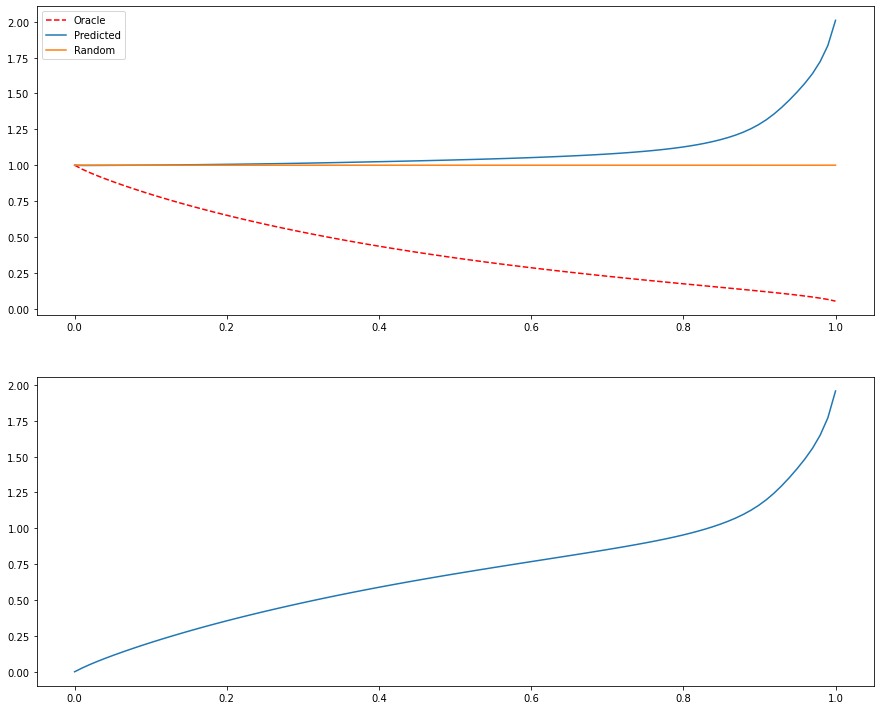

In [17]:
pred_curves, oracle_curves, random_curves = zip(*spars)

oracle = torch.stack(oracle_curves).mean(0)
pred_curve = torch.stack(pred_curves).mean(0)
random_curve = torch.stack(random_curves).mean(0)

error_curve = sparsification.error(oracle, pred_curve)
ause = sparsification.ause(oracle, pred_curve)
aurg = sparsification.aurg(pred_curve, random_curve)

figure, (curve_axis, error_axis) = plt.subplots(2, 1)

x_axis = np.linspace(0, 1, num=len(oracle))

curve_axis.plot(x_axis, oracle.numpy(), 'r--', label='Oracle')
curve_axis.plot(x_axis, pred_curve.numpy(), label='Predicted')
curve_axis.plot(x_axis, random_curve.numpy(), label='Random')
curve_axis.legend()

error_axis.plot(x_axis, error_curve.numpy())


figure.set_size_inches((15, 12.5))


print('Hamlyn test set Sparsification:'
      f'\n\t- AUSE: {ause}'
      f'\n\t- AURG: {aurg}')

results_dict['sparsification'] = {
    'ause': float(ause),
    'aurg': float(aurg),
    'curves': {
        'oracle': oracle.tolist(),
        'predicted': pred_curve.tolist(),
        'random': random_curve.tolist(),
        'error': error_curve.tolist()
    }
}

## SCARED MAE

### Setup

In [18]:
scared_model_path = os.path.join('models', 'scared', model_name)
scared_save_to = os.path.join(model_save_to, 'scared')

state_dict = torch.load(scared_model_path, map_location=device)
state_dict = prepare_state_dict(state_dict)

model.load_state_dict(state_dict)

scared_dataset_8 = SCAREDKeyframesLoader(scared_path, 'test', 8, scared_transform)
scared_dataloader_8 = DataLoader(scared_dataset_8, 1, shuffle=False)

print(f'Size of SCARED Dataset 8: {len(scared_dataset_8):,} images.')

scared_dataset_9 = SCAREDKeyframesLoader(scared_path, 'test', 9, scared_transform)
scared_dataloader_9 = DataLoader(scared_dataset_9, 1, shuffle=False)

print(f'Size of SCARED Dataset 9: {len(scared_dataset_9):,} images.')

Size of SCARED Dataset 8: 5 images.
Size of SCARED Dataset 9: 5 images.


### Run SCARED Evaluation

#### Dataset 8

In [19]:
scared_8_save_to = os.path.join(scared_save_to, 'dataset_8')

maes_8, metrics = evaluate_keyframes(model, scared_dataloader_8,
                                     min_depth, max_depth,
                                     save_results_to=scared_8_save_to,
                                     device=device)

mae_8_means, _ = zip(*maes_8)

mean_mae_8 = np.mean(mae_8_means)
std_mae_8 = np.std(mae_8_means)

print(f'Dataset 8 Keyframe MAEs: {maes_8} mm')
print('Absolute Depth Error on SCARED Dataset 8:'
      f'\n\t- Mean: {mean_mae_8} mm'
      f'\n\t- Std. Deviation: {std_mae_8} mm')

100%|██████████| 5/5 [00:18<00:00,  3.62s/batch, mae=82.9]

Dataset 8 Keyframe MAEs: [(36.53152851265579, 513.274919923145), (83.59595343236349, 401.54921859703603), (103.4169521860722, 344.52553968232894), (94.59548917790475, 629.9044575895219), (96.31808798641426, 564.7605844004971)] mm
Absolute Depth Error on SCARED Dataset 8:
	- Mean: 82.89160225908209 mm
	- Std. Deviation: 24.03453359634683 mm


#### Dataset 9

In [20]:
scared_9_save_to = os.path.join(scared_save_to, 'dataset_9')

maes_9, metrics = evaluate_keyframes(model, scared_dataloader_9,
                                     min_depth, max_depth,
                                     save_results_to=scared_9_save_to,
                                     device=device)
mae_9_means, _ = zip(*maes_9)

mean_mae_9 = np.mean(mae_9_means)
std_mae_9 = np.std(mae_9_means)

print(f'Dataset 8 Keyframe MAEs: {maes_9} mm')
print('Absolute Depth Error on SCARED Dataset 8:'
      f'\n\t- Mean: {mean_mae_9} mm'
      f'\n\t- Std. Deviation: {std_mae_9} mm')

100%|██████████| 5/5 [00:20<00:00,  4.12s/batch, mae=116] 

Dataset 8 Keyframe MAEs: [(88.67539724632947, 417.9516901091047), (126.71479627036817, 106.3872509294566), (89.04780220692695, 740.1983366205073), (127.86410374552702, 253.6953872432145), (149.22671395441162, 99.41347729862703)] mm
Absolute Depth Error on SCARED Dataset 8:
	- Mean: 116.30576268471263 mm
	- Std. Deviation: 23.79985615265115 mm


#### Save Results

In [21]:
results_dict['mae'] = {
    'dataset_8': {
        'mean': float(mean_mae_8),
        'std': float(std_mae_8)
    },
    'dataset_9': {
        'mean': float(mean_mae_9),
        'std': float(std_mae_9)
    }
}

## Save Results

In [22]:
save_to_path = os.path.join(save_to, model_stem, 'evaluation.json')

with open(save_to_path, 'w+') as f:
    json.dump(results_dict, f, indent=4)

## Sparsification Curves of all Models

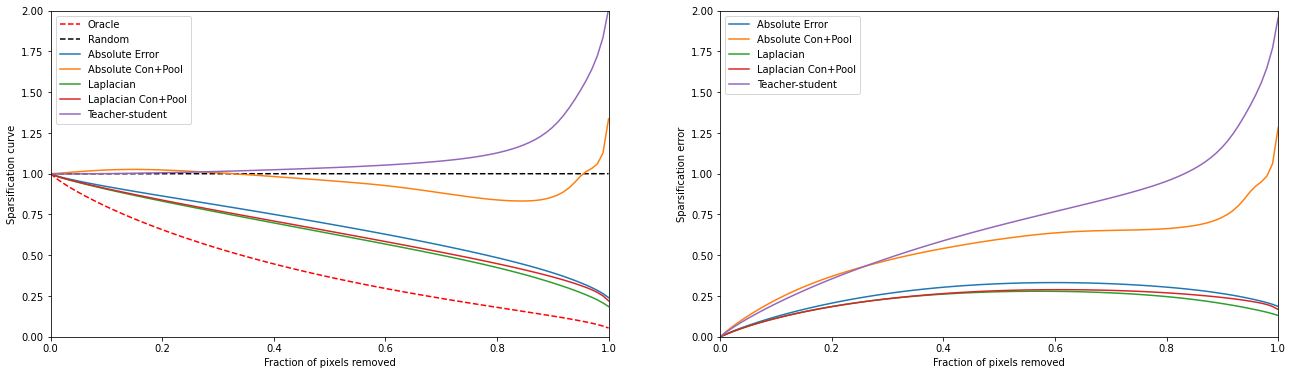

In [4]:
import glob

figure, (curve_axis, error_axis) = plt.subplots(1, 2)

model_names = {
    'log-con-pool': 'Laplacian Con+Pool',
    'log-vanilla': 'Laplacian',
    'l1-con-pool': 'Absolute Con+Pool',
    'l1-vanilla': 'Absolute Error',
    'teacher-student': 'Teacher-student'
}

results_glob = glob.glob('results/*/evaluation.json')

for i, result_path in enumerate(results_glob):
    route, _ = os.path.split(result_path)
    directory = os.path.basename(route)
    
    if directory not in model_names:
        continue
        
    model_name = model_names[directory]
    
    with open(result_path) as f:
        results = json.load(f)
    
    spars = results['sparsification']
    curves = spars['curves']

    
    if i == 0:
        x_axis = np.linspace(0, 1, num=len(curves['oracle']))
        
        curve_axis.plot(x_axis, curves['oracle'], 'r--', label='Oracle')
        curve_axis.plot(x_axis, curves['random'], 'k--', label='Random')
        
    curve_axis.plot(x_axis, curves['predicted'], label=model_name)
    error_axis.plot(x_axis, curves['error'], label=model_name)

curve_axis.legend()
error_axis.legend()

curve_axis.set_xlabel('Fraction of pixels removed')
curve_axis.set_ylabel('Sparsification curve')

error_axis.set_xlabel('Fraction of pixels removed')
error_axis.set_ylabel('Sparsification error')

curve_axis.set_xlim(0, 1)
curve_axis.set_ylim(0, 2)

error_axis.set_xlim(0, 1)
error_axis.set_ylim(0, 2)

figure.set_size_inches((22, 6))
